# Simulating LISA data

1. Generate LISA's orbit (`lisaorbit`)
2. Generate GW response (`lisagwresponse`)
3. Generate instrument noise (`lisainstrument`) and inject GW + Orbit data

Start by installing the required packages:

In [11]:
! pip install lisaorbits -q
! pip install lisagwresponse -q
! pip install lisainstrument -q
! pip install bilby -q --no-warn-script-location

In [12]:
%matplotlib inline
import lisaorbits, lisainstrument, lisagwresponse
import os
import numpy as np
from bilby.core.prior import Uniform, PriorDict, Normal

OUTDIR = "simulated_lisa_data"
os.makedirs(OUTDIR, exist_ok=True)
dt = 100000  # seconds
year_in_sec = 365.25 * 24 * 60 * 60  # seconds
datasize = int(year_in_sec / dt)
print(f"Datasize: {datasize}")

Datasize: 315


## LISA Orbit generation

Generate a simple Keplerian orbit with equal arm lengths for 1 years. Save the data.

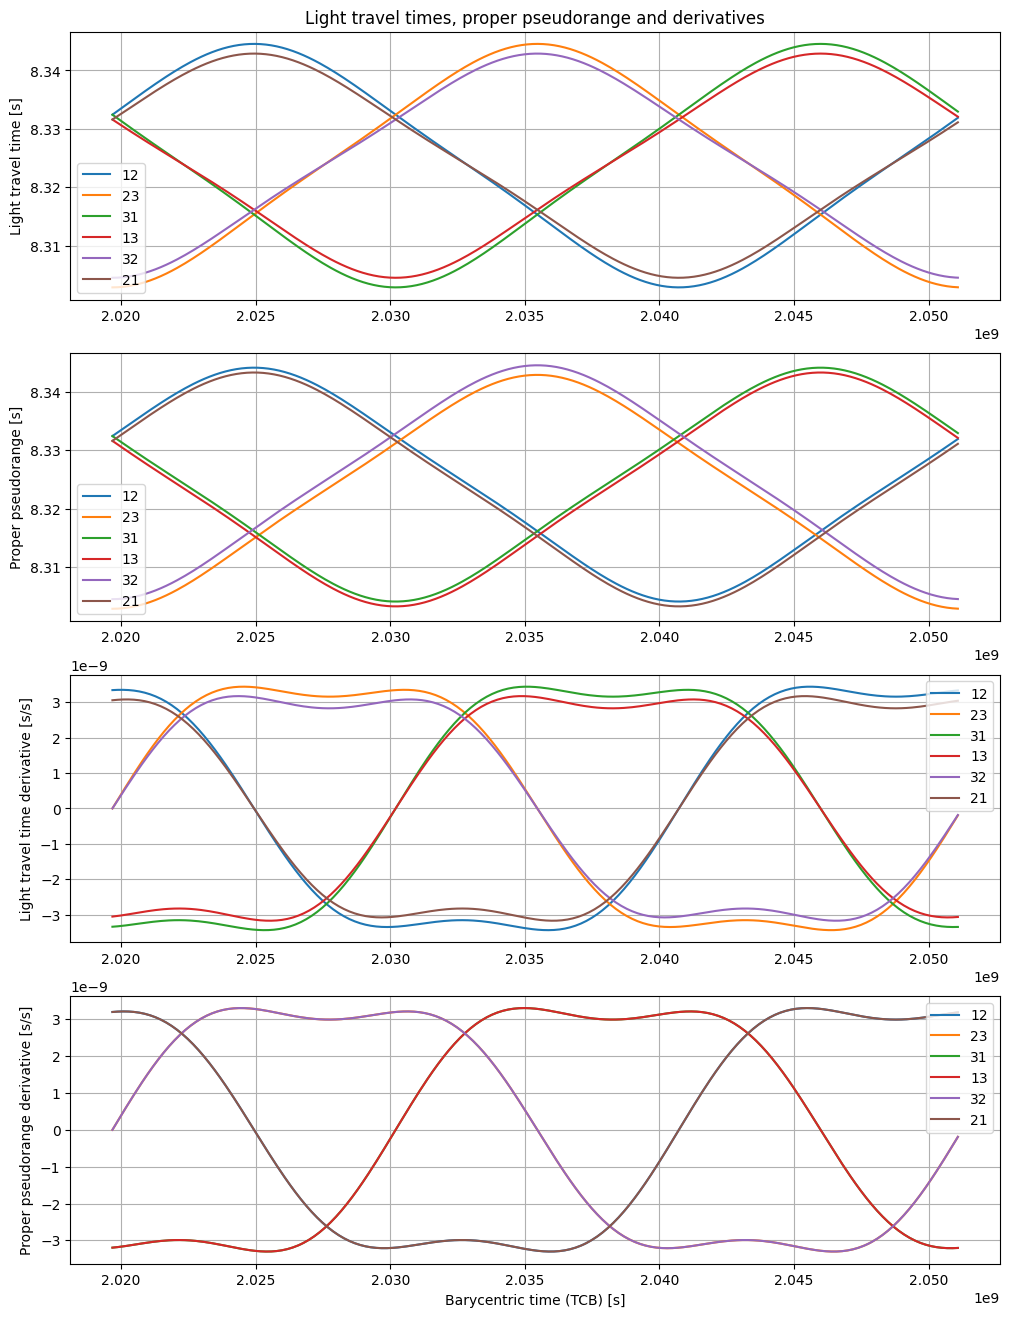

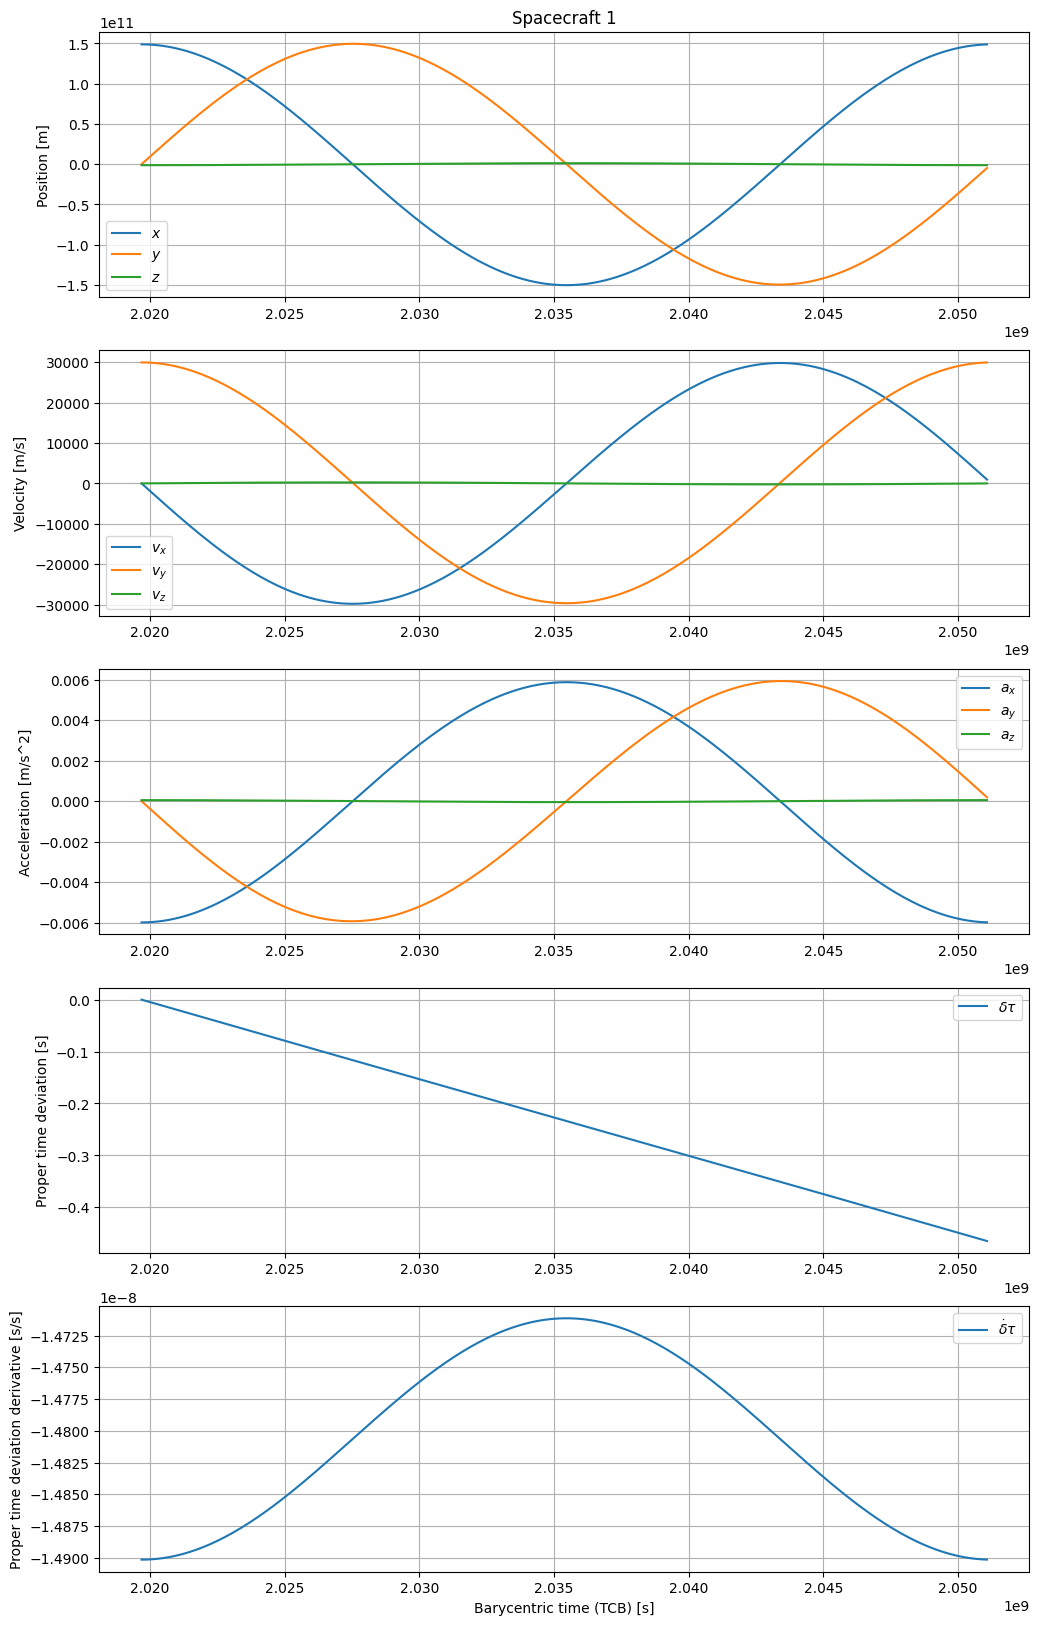

In [13]:
orbit = lisaorbits.KeplerianOrbits(
    L=2.5e9,  # m (arm length)
    dt=dt,  # seconds (data sampling time)
    size=datasize,  # number of data points
)
orbit_t0 = orbit.t[0]
orbits_fn = f"{OUTDIR}/keplerian.hdf5"
if not os.path.exists(orbits_fn):
    orbit.write(orbits_fn)

orbit.plot_links()
orbit.plot_spacecraft(sc=1)

## GW Response
Code to simulate different types of GW signals (given the LISA orbits)

You are using an orbit file in a version that might not be fully supported


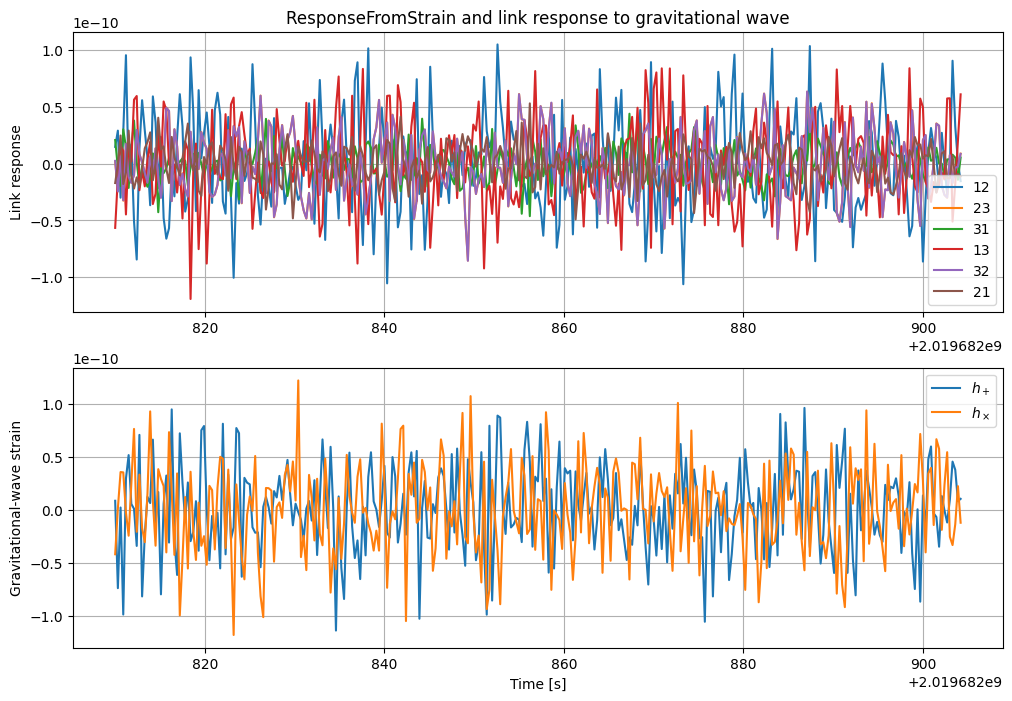

You are using an orbit file in a version that might not be fully supported


In [14]:
# Create a flat-spectrum source
generator = lisagwresponse.psd.white_generator(1E-21)
sgwb_white = lisagwresponse.StochasticPointSource(
    generator, orbits=orbits_fn, gw_beta=0, gw_lambda=0, size=datasize,
    t0=10.0 + orbit_t0
)
sgwb_white.plot(sgwb_white.t)
sgwb_white_fn = f"{OUTDIR}/sgwb_white.hdf5"
sgwb_white.write(sgwb_white_fn)

You are using an orbit file in a version that might not be fully supported


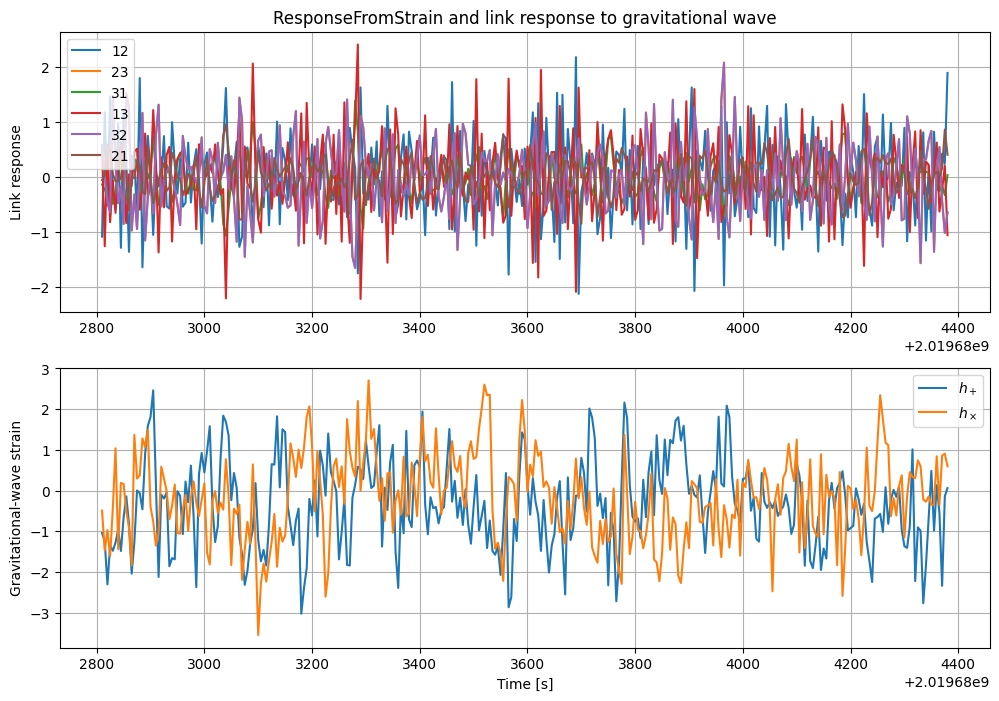

You are using an orbit file in a version that might not be fully supported


In [15]:
# Create a -2/3 power-law source
generator = lisagwresponse.psd.ifft_generator(lambda f: f ** (-2 / 3))
sgwb_powerlaw = lisagwresponse.StochasticPointSource(
    generator, orbits=orbits_fn, gw_beta=0, gw_lambda=0, dt=5,
    size=datasize, t0=10.0 + orbit_t0
)
sgwb_powerlaw.plot(sgwb_powerlaw.t)
sgwb_powerlaw_fn = f"{OUTDIR}/sgwb_powerlaw.hdf5"
sgwb_powerlaw.write(sgwb_powerlaw_fn)

You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit file in a version that might not be fully supported
You are using an orbit fi

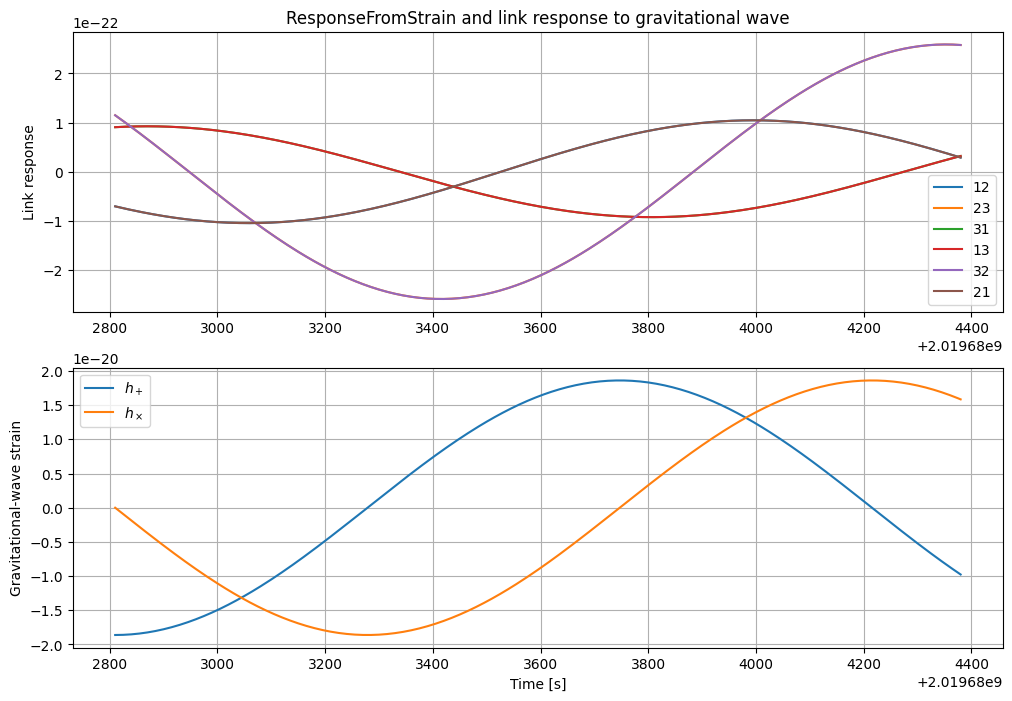

In [16]:
## Create 10 binaries
n_binaries = 10
injection_distribution = PriorDict(dict(
    A=Normal(mu=1E-21, sigma=1E-20),
    f=Uniform(5E-4, 2E-3),
    gw_beta=Uniform(0, np.pi / 2),
    gw_lambda=Uniform(0, 2 * np.pi),
))
binaries = []
for i in range(n_binaries):
    parms = injection_distribution.sample()
    binaries.append(
        lisagwresponse.GalacticBinary(
            parms['A'], parms['f'],
            gw_beta=parms['gw_beta'], gw_lambda=parms['gw_lambda'],
            dt=5, size=datasize, t0=10.0 + orbit_t0,
            orbits=orbits_fn
        )
    )
    binary_fn = f"{OUTDIR}/gw_binary_{i}.hdf5"
    binaries[-1].write(binary_fn)

binaries[0].plot(binaries[0].t)

In [17]:
# TODO Combine GW signals into one object

## LISA Instrument noise

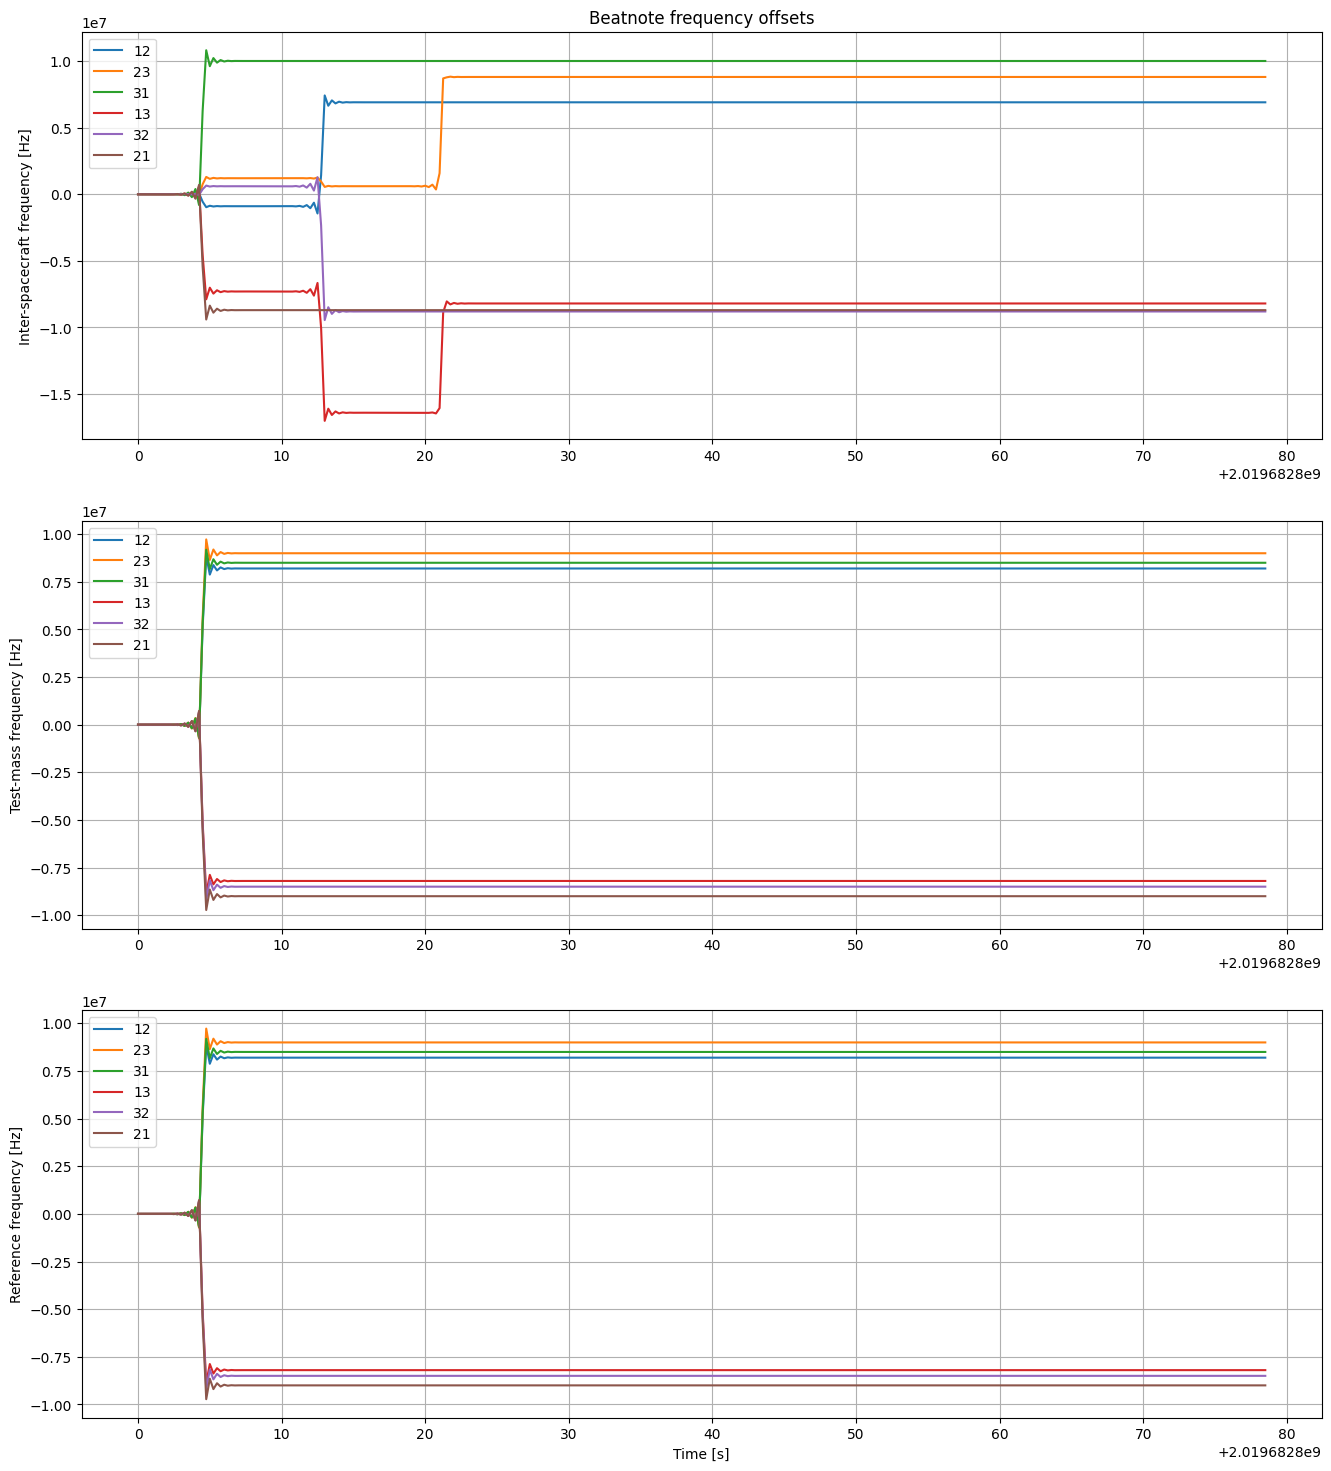

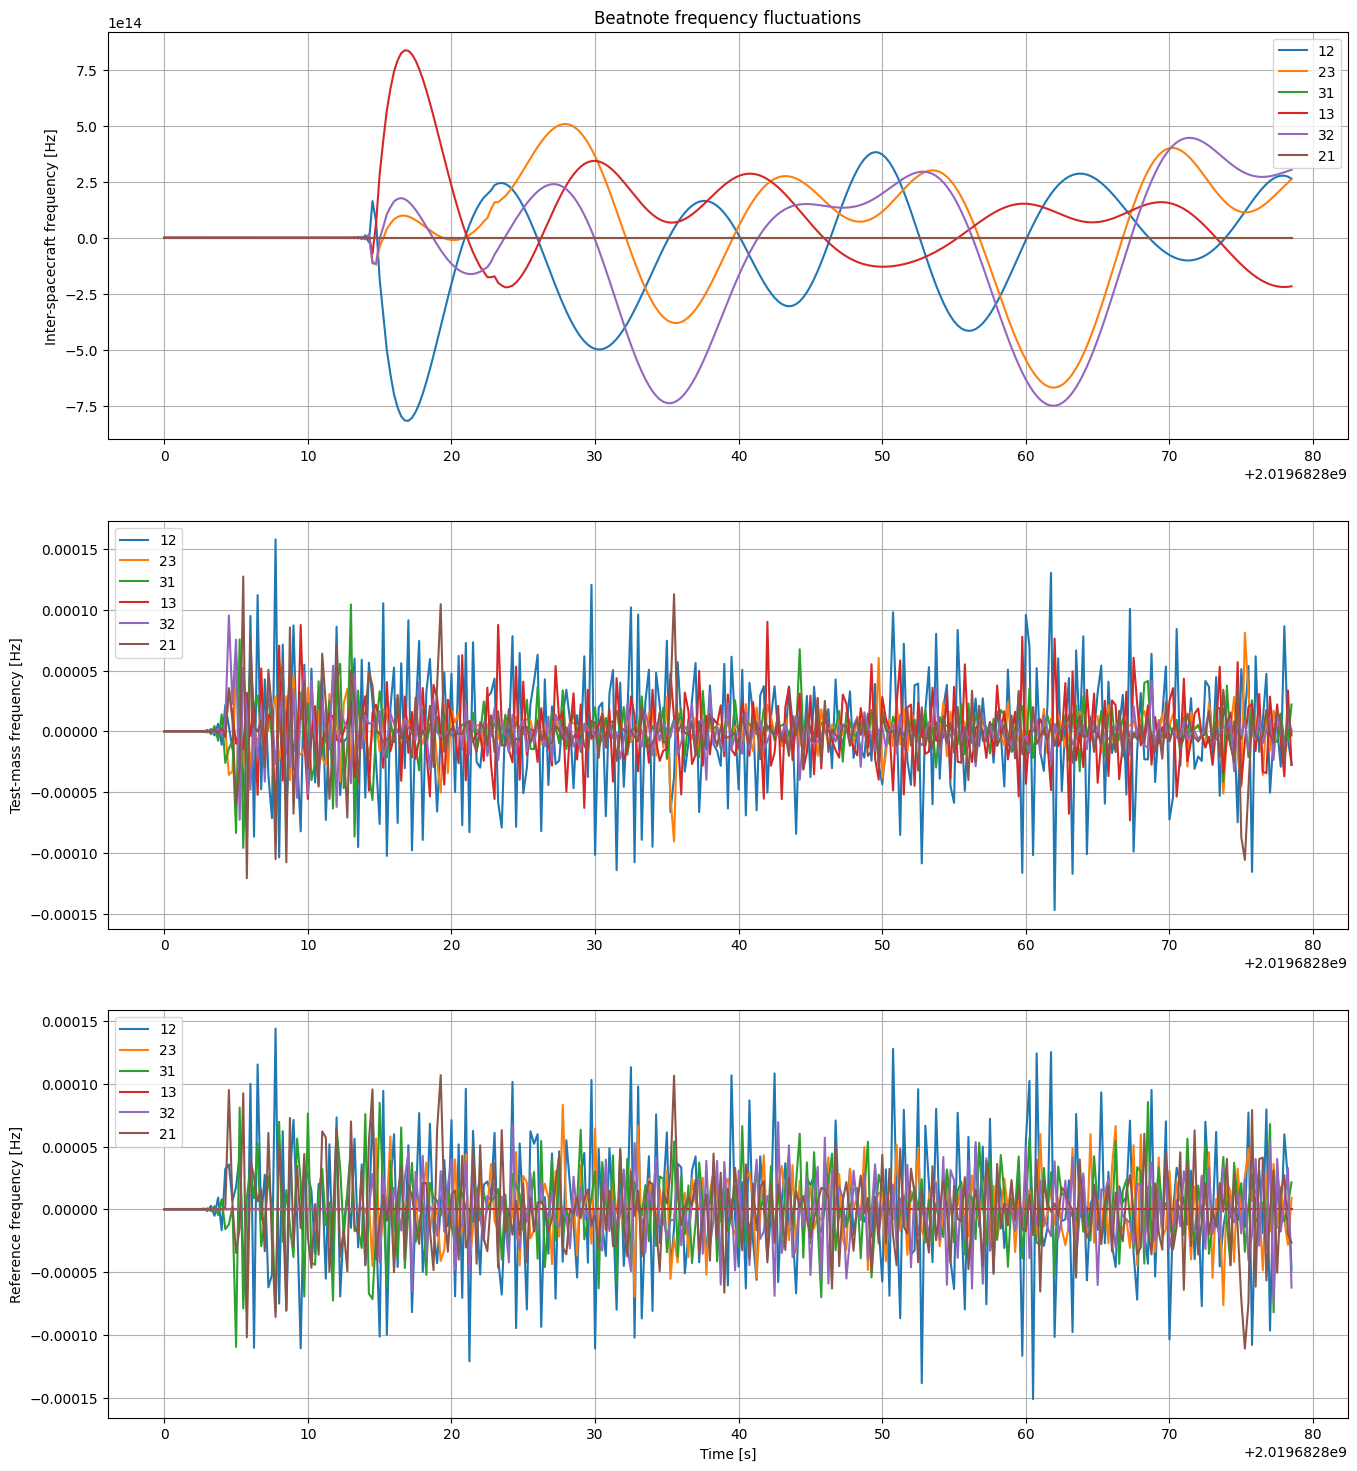

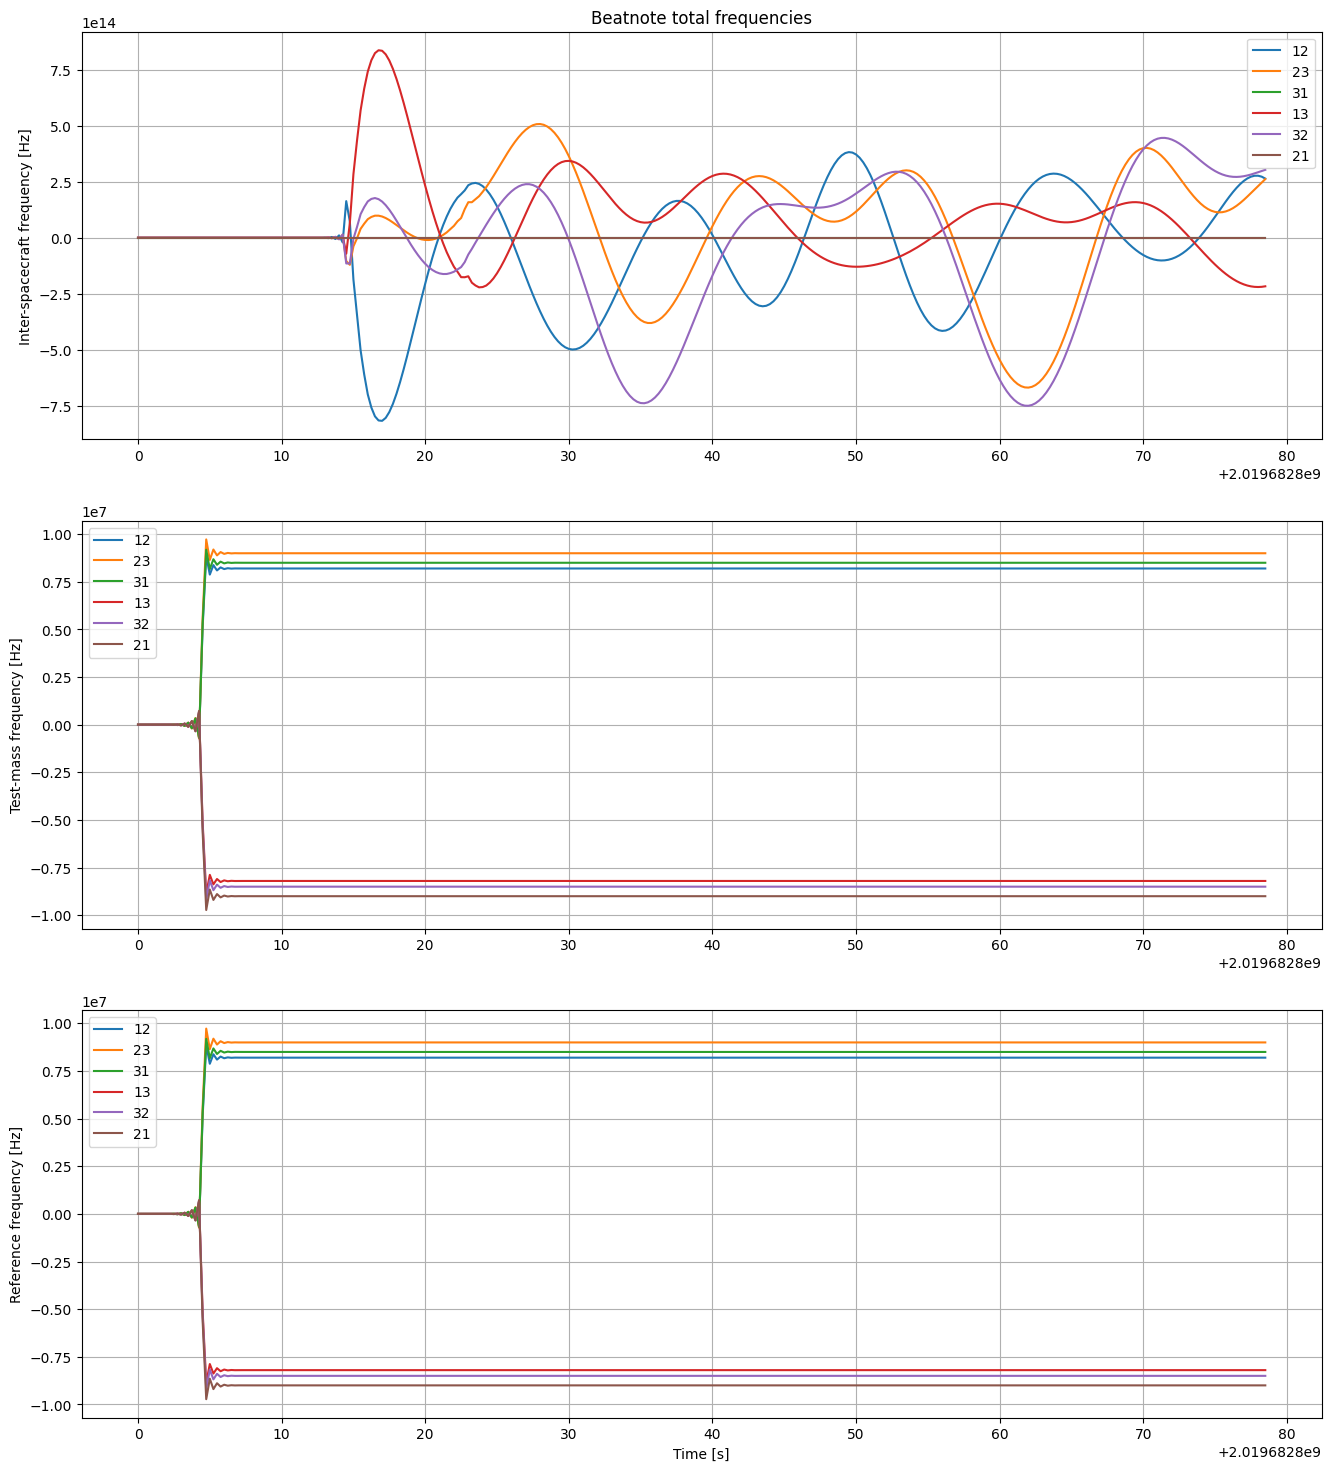

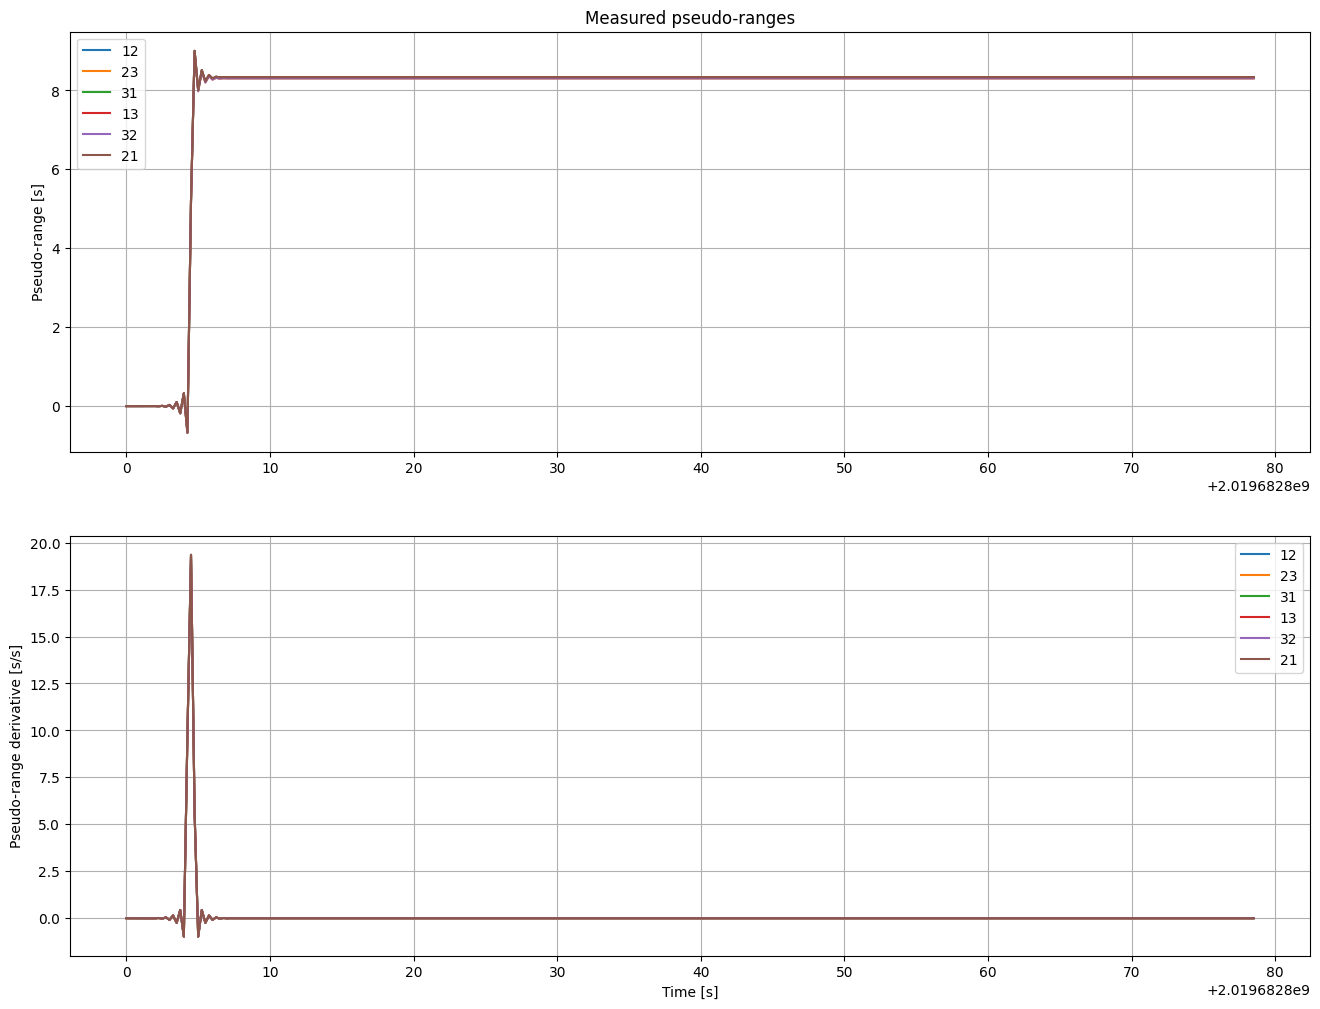

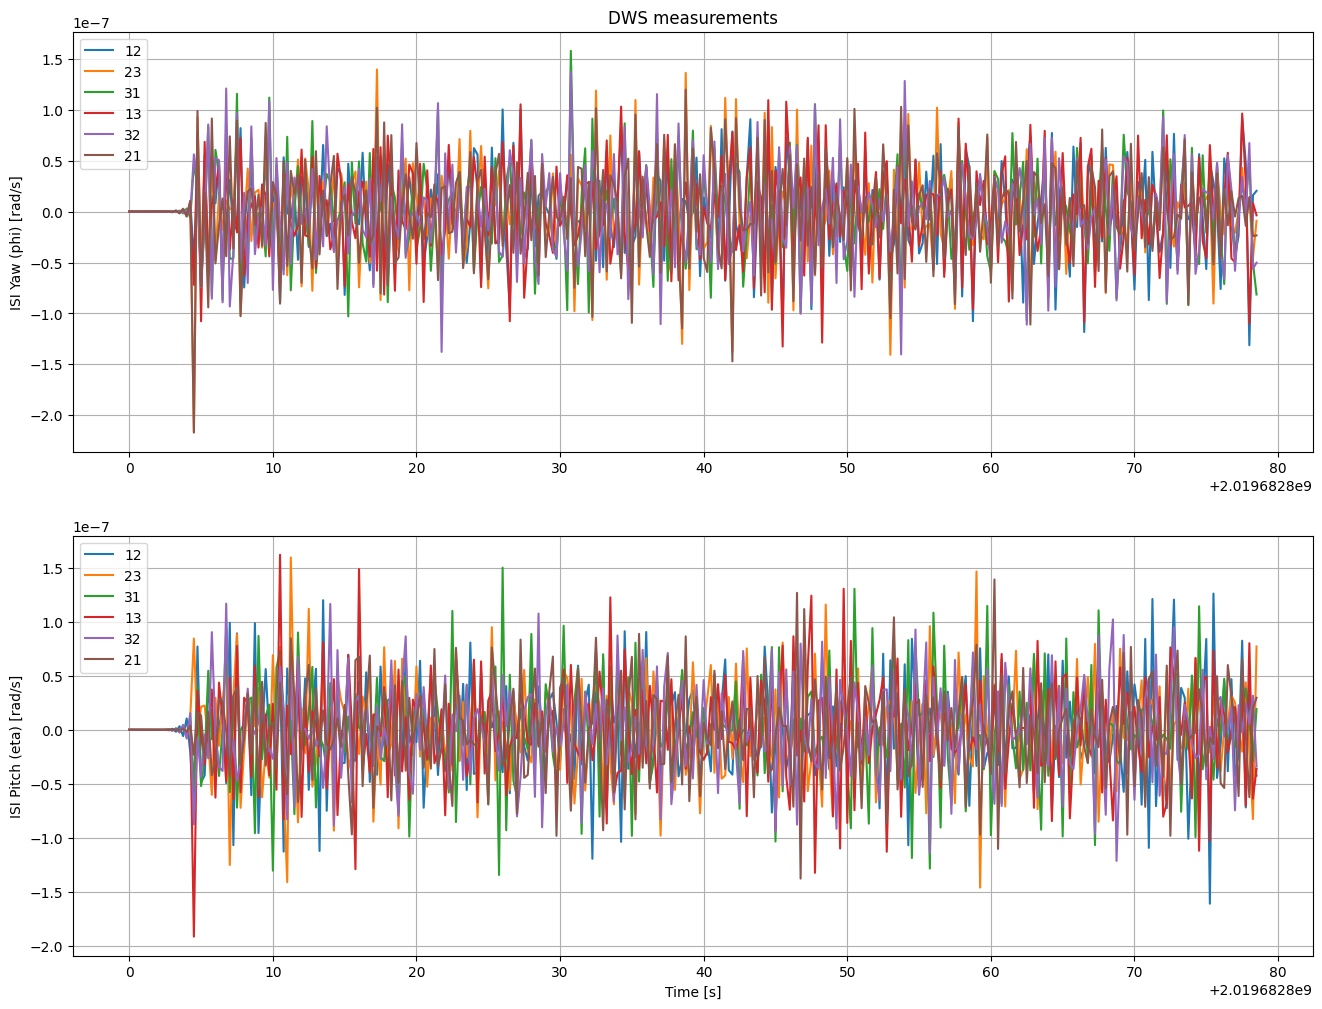

In [18]:
instrument = lisainstrument.Instrument(
    orbits=orbits_fn,
    size=datasize,
    gws=sgwb_powerlaw_fn,
)
instrument.simulate()
instrument.plot_offsets()
instrument.plot_fluctuations()
instrument.plot_totals()
instrument.plot_mprs()
instrument.plot_dws()